---

# **Imports**

In [2]:
import numpy as np
from scipy.stats import norm
import ot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, lognorm 

---

# **General Functions**

In [3]:
def c_lookback(x, y, K):
    return np.maximum(np.max(y) - K, 0) - x

def cost_matrix(xi, yj, K):
    return c_lookback(xi[:, None], yj, K)

def uniform_support(a, b, n):
    return np.linspace(a, b, n)

def project_onto_C1(p, mu):
    return p * (mu / (p.sum(axis=1) + 1e-8))

def project_onto_C2(p, nu):
    return p * (nu / (p.sum(axis=0) + 1e-8))

def project_onto_martingale_constraint(p, xi, yj, mu):
    expected_y_per_x = np.dot(p, yj) / (mu + 1e-8)
    adjustment_factors = xi / expected_y_per_x
    adjustment_factors = np.where(np.isnan(adjustment_factors), 1, adjustment_factors)
    p_adjusted = p * adjustment_factors[:, None]
    return p_adjusted

def bregman_projection(mu, nu, xi, yj, C, max_iter=100):
    m, n = C.shape
    p = np.exp(-C)
    p /= np.sum(p)
    for _ in range(max_iter):
        p = project_onto_C1(p, mu)
        p = project_onto_C2(p, nu)
        p = project_onto_martingale_constraint(p, xi, yj, mu)
        p /= np.sum(p)
    return p

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    lookback_call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) + S * sigma * np.sqrt(T) * (norm.cdf(d1) - np.exp(-r * T) * norm.cdf(d2))
    return lookback_call_price

---

# **Calculation with basic Black Scholes method**

In [4]:
# Parameters for the European call option
S = 100  # Initial stock price
K = 100  # Strike price
T = 1    # Time to maturity (in years)
r = 0.05 # Risk-free interest rate
sigma = 0.2  # Volatility

# Classic method: Black-Scholes pricing for lookback call option
classic_price = black_scholes_call(S, K, T, r, sigma)
print("Classic method (Black-Scholes) price for lookback call option:", classic_price)

Classic method (Black-Scholes) price for lookback call option: 12.540700286622679


# **Calculation with Monte Carlo Simulations**

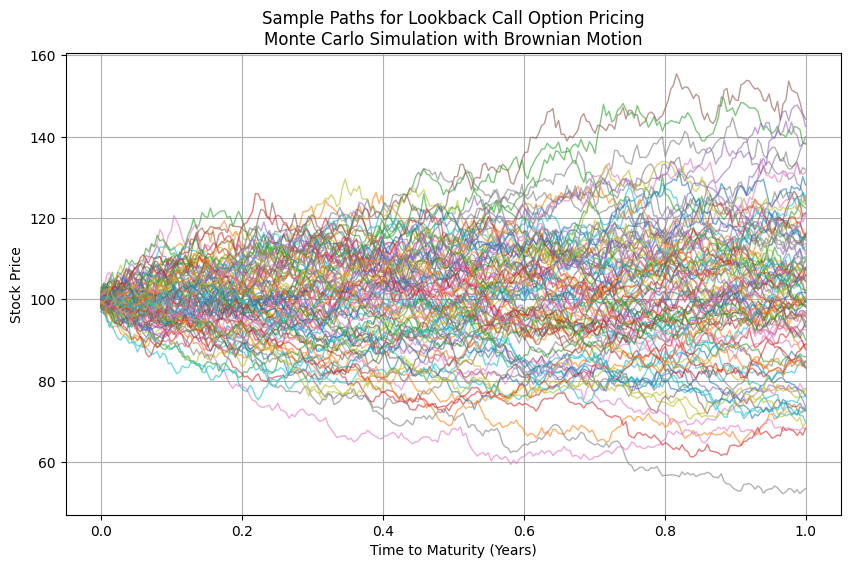

Monte Carlo simulation price for lookback call option: 18.280274784514432


In [14]:
# Parameters for the European call option
S = 100  # Initial stock price
K = 100  # Strike price (not directly used in floating strike lookback calculation)
T = 1    # Time to maturity (in years)
r = 0.05 # Risk-free interest rate
sigma = 0.2  # Volatility
n_trials = 10000  # Number of Monte Carlo trials
n_steps = 252  # Number of steps within the time to maturity

def monte_carlo_lookback_call_brownian_plot(S, K, T, r, sigma, n_trials, n_steps):
    dt = T / n_steps
    paths = []
    max_prices = np.zeros(n_trials)  # To keep track of the maximum stock price in each trial
    
    for i in range(n_trials):
        # Generate Brownian motion: cumulative sum of normal random increments
        increments = sigma * np.sqrt(dt) * np.random.normal(size=n_steps) + (r - 0.5 * sigma**2) * dt
        price_paths = S * np.exp(np.cumsum(increments))
        max_prices[i] = np.max(price_paths)
        if i < 100:  # Only store 100 paths for plotting to avoid overloading the plot
            paths.append(price_paths)
    
    # Compute the payoff for lookback option: max(S(t) - K, 0)
    payoffs = np.maximum(max_prices - S, 0)
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    for path in paths:
        plt.plot(np.linspace(0, T, n_steps), path, lw=1, alpha=0.6)
    plt.title('Sample Paths for Lookback Call Option Pricing\nMonte Carlo Simulation with Brownian Motion')
    plt.xlabel('Time to Maturity (Years)')
    plt.ylabel('Stock Price')
    plt.grid(True)
    plt.show()
    
    return option_price

# Running the simulation with plotting
lookback_call_price_with_plot = monte_carlo_lookback_call_brownian_plot(S, K, T, r, sigma, n_trials, n_steps)
print("Monte Carlo simulation price for lookback call option:", lookback_call_price_with_plot)


---

# **Calculation with our Bregman Projection method**

In [8]:
n = 100  # Number of support points for each distribution
xi = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
yj = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
C = cost_matrix(xi, yj, K)  # Use the updated cost matrix function
mu = stats.lognorm.pdf(xi, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
mu /= np.sum(mu)
nu = stats.lognorm.pdf(yj, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
nu /= np.sum(nu)
p_star_bregman = bregman_projection(mu, nu, xi, yj, C)
payoff_matrix = np.maximum(np.max(yj) - K, 0)  # Update the payoff matrix for lookback option
bregman_price = np.exp(-r * T) * np.sum(p_star_bregman * payoff_matrix)

print("Bregman projection price for lookback call option:", bregman_price)

Bregman projection price for lookback call option: 163.44802348151322


---

# **Sensitivity Analysis**

Compare the Black-Scholes model and our new Bregman Projection method.

In [11]:
# Parameters for the European call option
S = 100  # Initial stock price
K = 100  # Strike price
T = 1    # Time to maturity (in years)
r = 0.05 # Risk-free interest rate
sigma = 0.2  # Volatility

n = 100  # Number of support points for each distribution

Evaluate the sensitivity to change in initial stock price

In [12]:
# Sensitivity analysis for strike price
initial_prices = np.linspace(80, 120, 50)
classic_prices_initial = []
bregman_prices_initial = []
for S in initial_prices:
    classic_price = black_scholes_call(S, K, T, r, sigma)
    classic_prices_initial.append(classic_price)
    
    n = 100  # Number of support points for each distribution
    xi = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    yj = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    C = cost_matrix(xi, yj, K)  # Use the updated cost matrix function
    mu = stats.lognorm.pdf(xi, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    mu /= np.sum(mu)
    nu = stats.lognorm.pdf(yj, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    nu /= np.sum(nu)
    p_star_bregman = bregman_projection(mu, nu, xi, yj, C)
    payoff_matrix = np.maximum(np.max(yj) - K, 0)  # Update the payoff matrix for lookback option
    bregman_price = np.exp(-r * T) * np.sum(p_star_bregman * payoff_matrix)

    bregman_prices_initial.append(bregman_price)

Evaluate the sensitivity to change in strike prices

In [13]:
# Reset stock price
S = 100  # Initial stock price

In [14]:
# Sensitivity analysis for strike price
strike_prices = np.linspace(80, 120, 50)
classic_prices_strike = []
bregman_prices_strike = []
for K in strike_prices:
    classic_price = black_scholes_call(S, K, T, r, sigma)
    classic_prices_strike.append(classic_price)
    
    n = 100  # Number of support points for each distribution
    xi = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    yj = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    C = cost_matrix(xi, yj, K)  # Use the updated cost matrix function
    mu = stats.lognorm.pdf(xi, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    mu /= np.sum(mu)
    nu = stats.lognorm.pdf(yj, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    nu /= np.sum(nu)
    p_star_bregman = bregman_projection(mu, nu, xi, yj, C)
    payoff_matrix = np.maximum(np.max(yj) - K, 0)  # Update the payoff matrix for lookback option
    bregman_price = np.exp(-r * T) * np.sum(p_star_bregman * payoff_matrix)

    bregman_prices_strike.append(bregman_price)

Evaluate the sensitivity to change in maturity

In [15]:
# Reset strike price
K = 100  # Strike price

In [16]:
# Sensitivity analysis for time to maturity
maturities = np.linspace(0.5, 2, 50)
classic_prices_maturity = []
bregman_prices_maturity = []
for T in maturities:
    classic_price = black_scholes_call(S, K, T, r, sigma)
    classic_prices_maturity.append(classic_price)
    
    n = 100  # Number of support points for each distribution
    xi = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    yj = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    C = cost_matrix(xi, yj, K)  # Use the updated cost matrix function
    mu = stats.lognorm.pdf(xi, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    mu /= np.sum(mu)
    nu = stats.lognorm.pdf(yj, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    nu /= np.sum(nu)
    p_star_bregman = bregman_projection(mu, nu, xi, yj, C)
    payoff_matrix = np.maximum(np.max(yj) - K, 0)  # Update the payoff matrix for lookback option
    bregman_price = np.exp(-r * T) * np.sum(p_star_bregman * payoff_matrix)

    bregman_prices_maturity.append(bregman_price)

Evaluate the sensitivity to change in interest rate

In [17]:
# Reset TTM
T = 1    # Time to maturity (in years)

In [18]:
# Sensitivity analysis for risk-free interest rate
interest_rates = np.linspace(0.01, 0.1, 50)
classic_prices_interest = []
bregman_prices_interest = []
for r in interest_rates:
    classic_price = black_scholes_call(S, K, T, r, sigma)
    classic_prices_interest.append(classic_price)
    
    n = 100  # Number of support points for each distribution
    xi = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    yj = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    C = cost_matrix(xi, yj, K)  # Use the updated cost matrix function
    mu = stats.lognorm.pdf(xi, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    mu /= np.sum(mu)
    nu = stats.lognorm.pdf(yj, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    nu /= np.sum(nu)
    p_star_bregman = bregman_projection(mu, nu, xi, yj, C)
    payoff_matrix = np.maximum(np.max(yj) - K, 0)  # Update the payoff matrix for lookback option
    bregman_price = np.exp(-r * T) * np.sum(p_star_bregman * payoff_matrix)

    bregman_prices_interest.append(bregman_price)

Evaluate the sensitivity to change in volatility

In [19]:
# Reset risk-free
r = 0.05 # Risk-free interest rate

In [20]:
# Sensitivity analysis for risk-free interest rate
volatilities = np.linspace(0.2, 0.5, 50)
classic_prices_vol = []
bregman_prices_vol = []
for sigma in volatilities:
    classic_price = black_scholes_call(S, K, T, r, sigma)
    classic_prices_vol.append(classic_price)
    
    n = 100  # Number of support points for each distribution
    xi = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    yj = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    C = cost_matrix(xi, yj, K)  # Use the updated cost matrix function
    mu = stats.lognorm.pdf(xi, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    mu /= np.sum(mu)
    nu = stats.lognorm.pdf(yj, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    nu /= np.sum(nu)
    p_star_bregman = bregman_projection(mu, nu, xi, yj, C)
    payoff_matrix = np.maximum(np.max(yj) - K, 0)  # Update the payoff matrix for lookback option
    bregman_price = np.exp(-r * T) * np.sum(p_star_bregman * payoff_matrix)

    bregman_prices_vol.append(bregman_price)

C:\Users\monde\AppData\Local\Temp\ipykernel_3588\3441371068.py:18: RuntimeWarning: overflow encountered in divide
  adjustment_factors = xi / expected_y_per_x
C:\Users\monde\AppData\Local\Temp\ipykernel_3588\3441371068.py:20: RuntimeWarning: invalid value encountered in multiply
  p_adjusted = p * adjustment_factors[:, None]
C:\Users\monde\AppData\Local\Temp\ipykernel_3588\3441371068.py:18: RuntimeWarning: divide by zero encountered in divide
  adjustment_factors = xi / expected_y_per_x


### **Visualization of our sensitivity analysis**

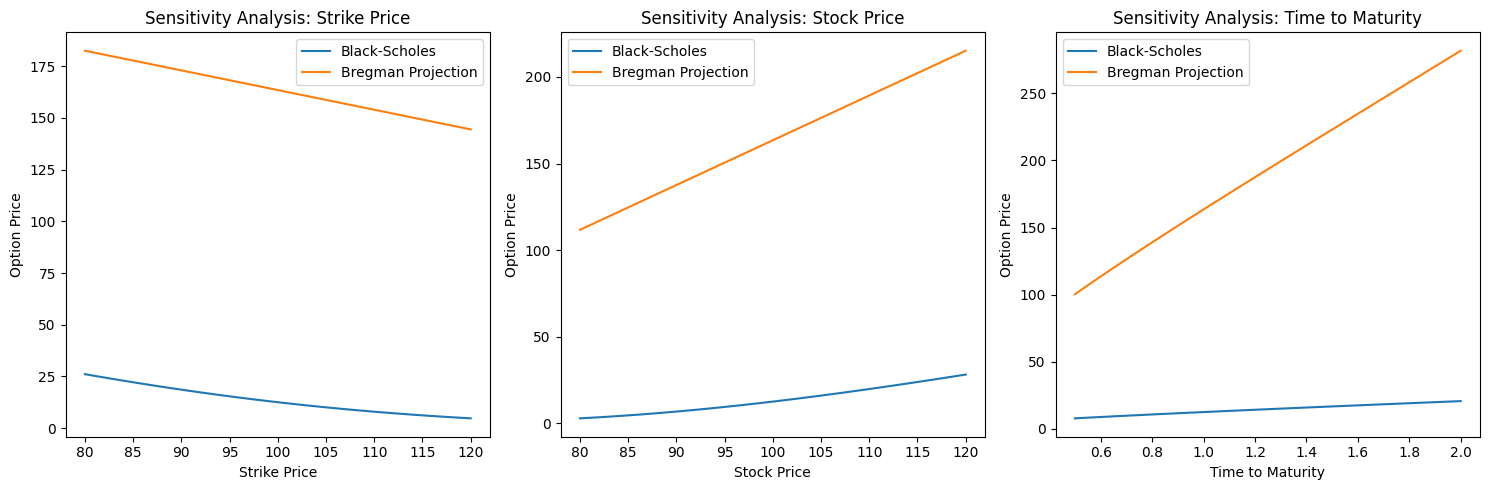

In [21]:
# Stock Price, Strike Price and Maturity
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[1].plot(initial_prices, classic_prices_initial, label='Black-Scholes')
axs[1].plot(initial_prices, bregman_prices_initial, label='Bregman Projection')
axs[1].set_xlabel('Stock Price')
axs[1].set_ylabel('Option Price')
axs[1].set_title('Sensitivity Analysis: Stock Price')
axs[1].legend()

axs[0].plot(strike_prices, classic_prices_strike, label='Black-Scholes')
axs[0].plot(strike_prices, bregman_prices_strike, label='Bregman Projection')
axs[0].set_xlabel('Strike Price')
axs[0].set_ylabel('Option Price')
axs[0].set_title('Sensitivity Analysis: Strike Price')
axs[0].legend()

axs[2].plot(maturities, classic_prices_maturity, label='Black-Scholes')
axs[2].plot(maturities, bregman_prices_maturity, label='Bregman Projection')
axs[2].set_xlabel('Time to Maturity')
axs[2].set_ylabel('Option Price')
axs[2].set_title('Sensitivity Analysis: Time to Maturity')
axs[2].legend()

plt.tight_layout()
plt.show()

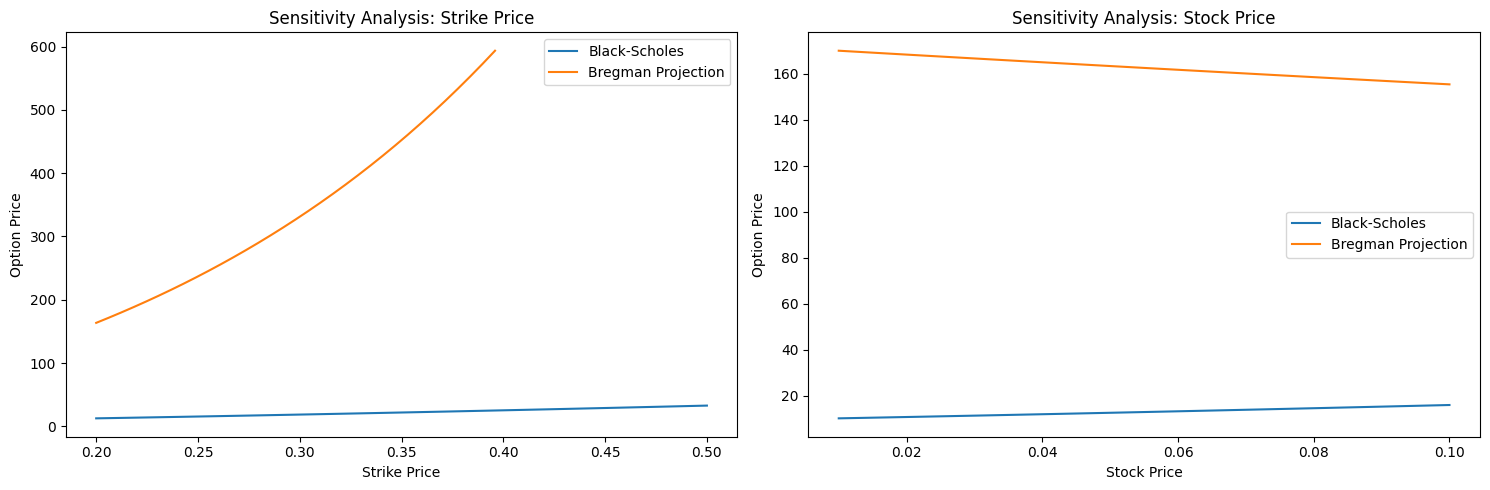

In [22]:
# Stock Price, Strike Price and Maturity
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[1].plot(interest_rates, classic_prices_interest, label='Black-Scholes')
axs[1].plot(interest_rates, bregman_prices_interest, label='Bregman Projection')
axs[1].set_xlabel('Stock Price')
axs[1].set_ylabel('Option Price')
axs[1].set_title('Sensitivity Analysis: Stock Price')
axs[1].legend()

axs[0].plot(volatilities, classic_prices_vol, label='Black-Scholes')
axs[0].plot(volatilities, bregman_prices_vol, label='Bregman Projection')
axs[0].set_xlabel('Strike Price')
axs[0].set_ylabel('Option Price')
axs[0].set_title('Sensitivity Analysis: Strike Price')
axs[0].legend()

plt.tight_layout()
plt.show()

Our bregman projection overprice a little bit the classic price but give consistent and logic results.

### **Numerical error analysis**

In [23]:
# Fix NaNs value in the volatility
bregman_prices_vol = [value for value in bregman_prices_vol if not np.isnan(value)]
classic_prices_vol = classic_prices_vol[:len(bregman_prices_vol)]

In [24]:
# Calculate and print the numerical error
error_stock = np.mean(np.abs(np.array(classic_prices_initial) - np.array(bregman_prices_initial)) / np.array(classic_prices_initial))
error_strike = np.mean(np.abs(np.array(classic_prices_strike) - np.array(bregman_prices_strike)) / np.array(classic_prices_strike))
error_maturity = np.mean(np.abs(np.array(classic_prices_maturity) - np.array(bregman_prices_maturity)) / np.array(classic_prices_maturity))
error_interest = np.mean(np.abs(np.array(classic_prices_interest) - np.array(bregman_prices_interest)) / np.array(classic_prices_interest))
error_vol = np.mean(np.abs(np.array(classic_prices_vol) - np.array(bregman_prices_vol)) / np.array(classic_prices_vol))

In [25]:
print(f"Numerical error (stock price): {error_stock:.2%}")
print(f"Numerical error (strike price): {error_strike:.2%}")
print(f"Numerical error (time to maturity): {error_maturity:.2%}")
print(f"Numerical error (Interest rates): {error_interest:.2%}")
print(f"Numerical error (Volatility): {error_vol:.2%}")

Numerical error (stock price): 1510.28%
Numerical error (strike price): 1391.07%
Numerical error (time to maturity): 1217.97%
Numerical error (Interest rates): 1186.58%
Numerical error (Volatility): 1701.34%
